## HW2
Name: Pei Tian (pt2632)


### C2: Time Measurement for Code in C1

### C3: 

In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt

num_workers = []
epoch_idx = []
elapsed_time = []
dataload_time = []
train_time = []

worker = None
def parse_log(file_path):
    with open(file_path, 'r') as file:
        log_content = file.read()
    
    # Regular expression to match different pieces of information
    worker_pattern = r"Benchmarking with (\d+) workers\.\.\."
    # epoch_pattern = r"Epoch (\d+):"
    benchmark_pattern = r"Epoch (\d+), elapsed: ([\d\.]+)s, dataload: ([\d\.]+)s, training: ([\d\.]+)s"
    accuracy_pattern = r"per-batch loss: ([\d\.]+), top1 accuracy: ([\d\.]+)"
    
    # Find all benchmarks
    benchmarks = re.findall(worker_pattern, log_content)
    data = []
    
    for workers in benchmarks:
        # Find all epochs related to current number of workers
        start_idx = log_content.find(f"Benchmarking with {workers} workers...")
        if int(workers) < int(benchmarks[-1]):
            end_idx = log_content.find(f"Benchmarking with {str(int(workers) + 4)} workers...")
        else:
            end_idx = len(log_content)
        
        worker_log = log_content[start_idx:end_idx]
        epochs = re.findall(benchmark_pattern, worker_log)
        
        for epoch, elapsed, dataload, training in epochs:
            epoch_data = {
                "Workers": int(workers),
                "Epoch": int(epoch),
                "Elapsed Time (s)": float(elapsed),
                "Data Load Time (s)": float(dataload),
                "Training Time (s)": float(training)
            }
            # Check if there is accuracy data available for the last epoch
            loss_accuracy = re.search(accuracy_pattern, worker_log)
            if loss_accuracy:
                epoch_data["Loss"] = float(loss_accuracy.group(1))
                epoch_data["Top1 Accuracy"] = float(loss_accuracy.group(2))
            
            data.append(epoch_data)
    
    return pd.DataFrame(data)
df = parse_log('C3.log')
df.head()

,Workers,Epoch,Elapsed Time (s),Data Load Time (s),Training Time (s),Loss,Top1 Accuracy
0,0,1,25.4854,20.2629,4.2749,1.527078,0.7188
1,0,2,24.9609,20.2506,3.7664,1.527078,0.7188
2,0,3,24.8606,20.1406,3.7722,1.527078,0.7188
3,0,4,24.9625,20.2395,3.7841,1.527078,0.7188
4,0,5,24.7537,20.0626,3.7595,1.527078,0.7188


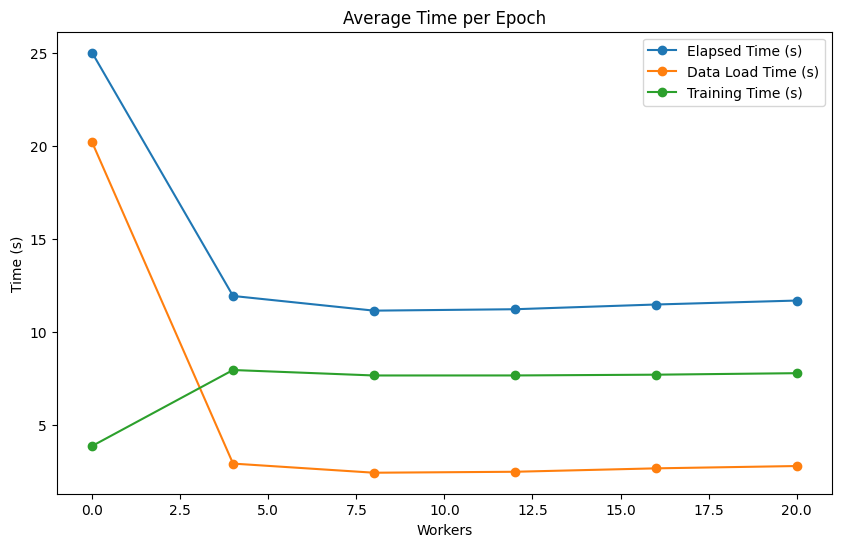

In [10]:
df.groupby('Workers')[['Elapsed Time (s)', 'Data Load Time (s)', 'Training Time (s)']].mean()\
    .plot(kind='line', figsize=(10, 6), marker='o', title='Average Time per Epoch')
plt.ylabel('Time (s)')
plt.show()